In [2]:
import warnings
warnings.filterwarnings("ignore")

from joblib import dump

import numpy as np 
import pandas as pd 

import shap
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
from yellowbrick.classifier import ConfusionMatrix


from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import  XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report
)

# Import data Risc Credit 

In [3]:
df = pd.read_csv('credit_data.csv')
df.head(5)

,i#clientid,income,age,loan,c#default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


# Sobre os dados 
- i#clientid	- id do cliente
- income - renda 
- age - idade 
- loan - empréstimo
- c#default - target aprova ou não credit para o cliente

In [4]:
df.describe()  # caracteristicas estatisticas

,i#clientid,income,age,loan,c#default
count,2000.000000,2000.000000,1997.000000,2000.000000,2000.000000
mean,1000.500000,45331.600018,40.807559,4444.369695,0.141500
std,577.494589,14326.327119,13.624469,3045.410024,0.348624
min,1.000000,20014.489470,-52.423280,1.377630,0.000000
25%,500.750000,32796.459717,28.990415,1939.708847,0.000000
50%,1000.500000,45789.117313,41.317159,3974.719419,0.000000
75%,1500.250000,57791.281668,52.587040,6432.410625,0.000000
max,2000.000000,69995.685578,63.971796,13766.051239,1.000000


In [5]:
df[df['loan'] <= 1.377630] # pegando cliente com emprestimo menor ou igual 1.377630 

,i#clientid,income,age,loan,c#default
865,866,28072.604355,54.142548,1.37763,0


In [6]:
df[df['income'] >= 69995.685578] # pegando cliente com renda maior ou igual 69995.685578

,i#clientid,income,age,loan,c#default
422,423,69995.685578,52.719673,2084.370861,0


# Visualização de dados 

- 1. Para Age

<AxesSubplot:xlabel='age', ylabel='Density'>

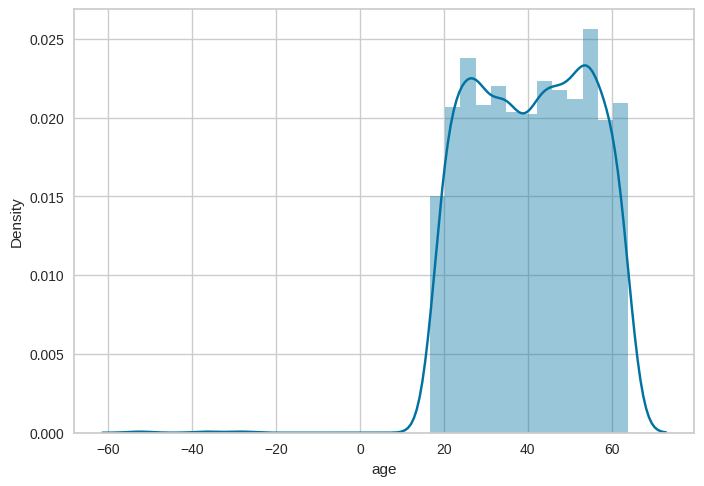

In [7]:
sns.distplot(df.age)

- 2. Para income

<AxesSubplot:xlabel='income', ylabel='Density'>

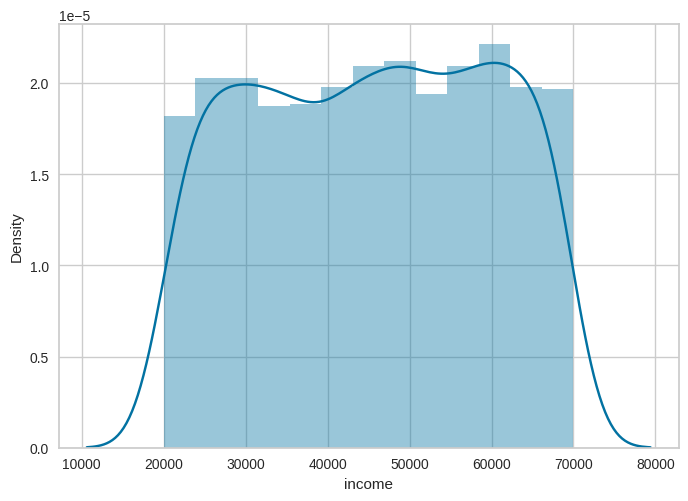

In [8]:
sns.distplot(df.income)


- 3. Para Loan

<AxesSubplot:xlabel='loan', ylabel='Density'>

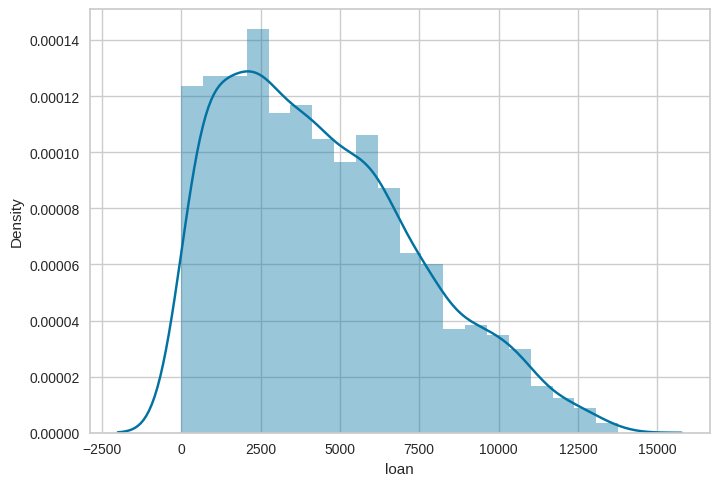

In [9]:
sns.distplot(df.loan)

# Pré - Processamento

 - 1. Inconsistência de dados

In [10]:
# vamos verificar os registros de idade menor que zero 
df.loc[df['age'] < 0] 

,i#clientid,income,age,loan,c#default
15,16,50501.726689,-28.218361,3977.287432,0
21,22,32197.620701,-52.423280,4244.057136,0
26,27,63287.038908,-36.496976,9595.286289,0


In [11]:
# Agora vamos converter de valor neagtivo para positivo
df.loc[df['age'] < 0] = abs(df.loc[df['age'] < 0])

In [12]:
# Veja que não há mais pessoas com idade negativa
df.loc[df['i#clientid'].isin([16, 22, 27])]

,i#clientid,income,age,loan,c#default
15,16,50501.726689,28.218361,3977.287432,0
21,22,32197.620701,52.423280,4244.057136,0
26,27,63287.038908,36.496976,9595.286289,0


- 2. Dados Faltantes

In [13]:
df.isnull().sum()

i#clientid    0
income        0
age           3
loan          0
c#default     0
dtype: int64

In [14]:
# verificando quais são os registros
df.loc[pd.isnull(df['age'])]  

,i#clientid,income,age,loan,c#default
28,29,59417.805406,NaN,2082.625938,0
30,31,48528.852796,NaN,6155.784670,0
31,32,23526.302555,NaN,2862.010139,0


In [15]:
# Preenchendo os dados faltantes pela media
df['age'].fillna(df['age'].mean(), inplace = True)

In [16]:
# verificar os campos anteriores
df.loc[df['i#clientid'].isin([29, 31, 32])]

,i#clientid,income,age,loan,c#default
28,29,59417.805406,40.924874,2082.625938,0
30,31,48528.852796,40.924874,6155.784670,0
31,32,23526.302555,40.924874,2862.010139,0


# Verificando como esta as nossas classes no target

 Percebe-se que nossas classes estão desbalanceadas, mas a frente vamos contornar esta situação, 
 mas antes iremos separar as features classificadoras do target que contem as nossas classes, valores de X e y

(array([0, 1]), array([1717,  283]))


<AxesSubplot:xlabel='c#default', ylabel='count'>

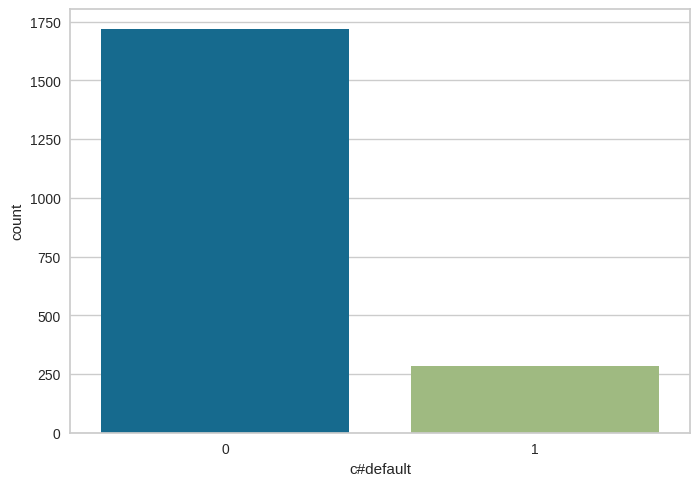

In [17]:
print(np.unique(df['c#default'], return_counts=True)) 

sns.countplot(x = df['c#default'])

# Definindo features Classificadoras e as Classes

In [18]:
X = df.drop(columns=['i#clientid', 'c#default'], axis=1)
y = df['c#default']

In [19]:
X.describe()

,income,age,loan
count,2000.000000,2000.000000,2000.000000
mean,45331.600018,40.924874,4444.369695
std,14326.327119,13.257782,3045.410024
min,20014.489470,18.055189,1.377630
25%,32796.459717,29.062492,1939.708847
50%,45789.117313,41.310898,3974.719419
75%,57791.281668,52.582340,6432.410625
max,69995.685578,63.971796,13766.051239


# Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# SMOTE

In [21]:
smt = SMOTE()

X_train, y_train = smt.fit_resample(X_train, y_train)

# Naive Bayes

In [22]:
clf_nb = GaussianNB()

clf_nb.fit(X_train, y_train)

previsoes_nb = clf_nb.predict(X_test)

In [23]:
print(f'Acuracia: {accuracy_score(y_test, previsoes_nb).round(3) * 100}%')

Acuracia: 88.0%


0.88

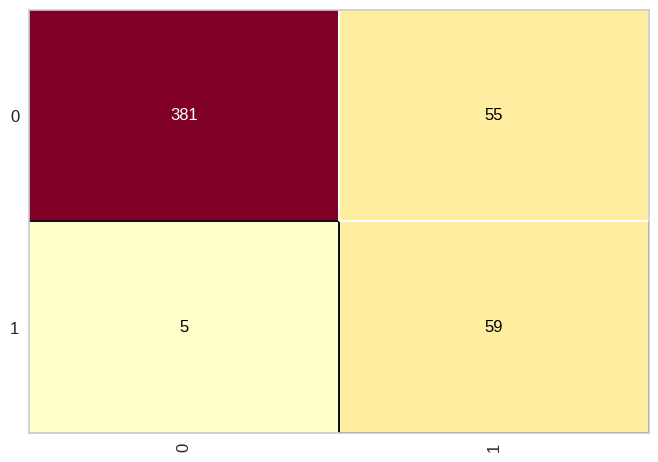

In [24]:
clf_nb = ConfusionMatrix(clf_nb)

clf_nb.fit(X_train, y_train)

clf_nb.score(X_test, y_test)

In [25]:
print(classification_report(y_test, previsoes_nb))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       436
           1       0.52      0.92      0.66        64

    accuracy                           0.88       500
   macro avg       0.75      0.90      0.79       500
weighted avg       0.93      0.88      0.89       500



# Decision Tree

In [26]:
clf_dt = DecisionTreeClassifier(max_depth=5,  random_state=1)

clf_dt_fitted = clf_dt.fit(X_train, y_train)

previsoes_dt = clf_dt_fitted.predict(X_test)

In [27]:
print(f'Acuracia: {accuracy_score(y_test, previsoes_dt).round(4) * 100}%')

Acuracia: 96.0%


0.96

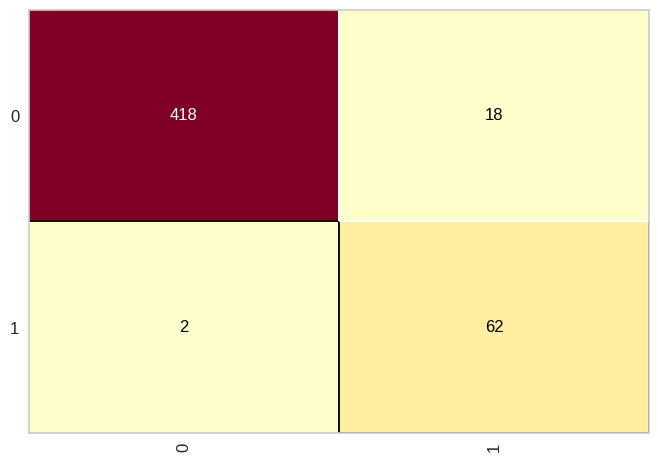

In [28]:
clf_dt = ConfusionMatrix(clf_dt_fitted)

clf_dt.fit(X_train, y_train)

clf_dt.score(X_test, y_test)

In [29]:
print(classification_report(y_test, previsoes_dt))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       436
           1       0.78      0.97      0.86        64

    accuracy                           0.96       500
   macro avg       0.89      0.96      0.92       500
weighted avg       0.97      0.96      0.96       500



# Random Forest 

In [30]:
clf_rf = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state = 1)

clf_rf.fit(X_train, y_train)

previsoes_rf = clf_rf.predict(X_test)

In [31]:
print(f'Acuracia: {accuracy_score(y_test, previsoes_rf).round(3) * 100}%')

Acuracia: 98.6%


0.986

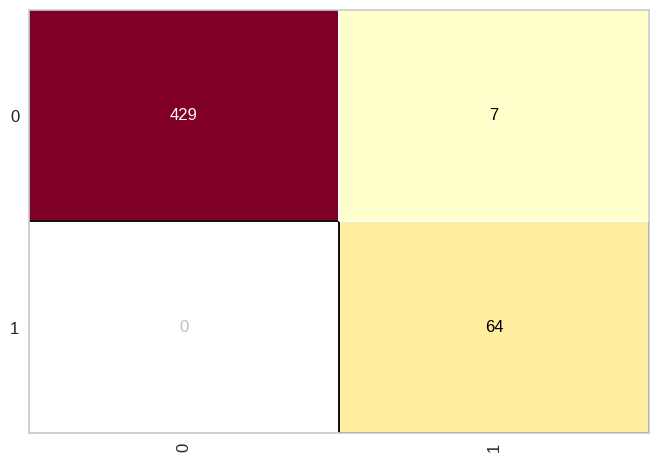

In [32]:
clf_rf = ConfusionMatrix(clf_rf)

clf_rf.fit(X_train, y_train)

clf_rf.score(X_test, y_test)

In [33]:
print(classification_report(y_test, previsoes_rf))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       436
           1       0.90      1.00      0.95        64

    accuracy                           0.99       500
   macro avg       0.95      0.99      0.97       500
weighted avg       0.99      0.99      0.99       500



# KNN

In [34]:
clf_knn = KNeighborsClassifier(n_neighbors=3)

clf_knn.fit(X_train, y_train)

previsoes_knn = clf_knn.predict(X_test)

print(f'Acuracia: {accuracy_score(y_test, previsoes_knn).round(3) * 100}%')

Acuracia: 79.4%


0.794

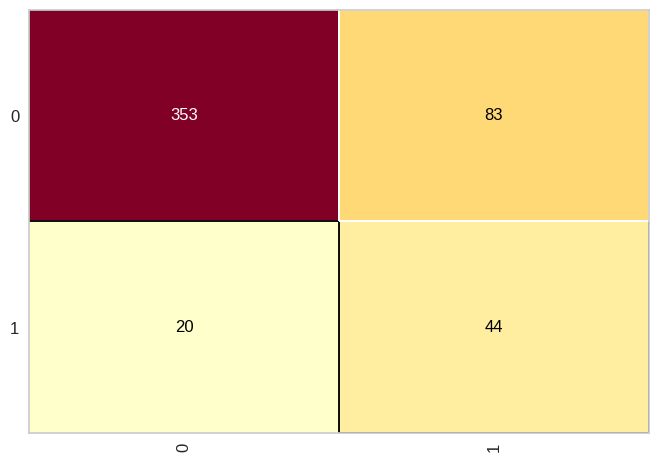

In [35]:
clf_knn = ConfusionMatrix(clf_knn)

clf_knn.fit(X_train, y_train)

clf_knn.score(X_test, y_test)

In [36]:
print(classification_report(y_test, previsoes_knn))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       436
           1       0.35      0.69      0.46        64

    accuracy                           0.79       500
   macro avg       0.65      0.75      0.67       500
weighted avg       0.87      0.79      0.82       500



# SVM

In [37]:
clf_svm = SVC(kernel='rbf', random_state=1, C = 2.0)

clf_svm.fit(X_train, y_train)

previsoes_svm = clf_svm.predict(X_test)

print(f'Acuracia: {accuracy_score(y_test, previsoes_svm).round(3) * 100} %')

Acuracia: 74.6 %


0.746

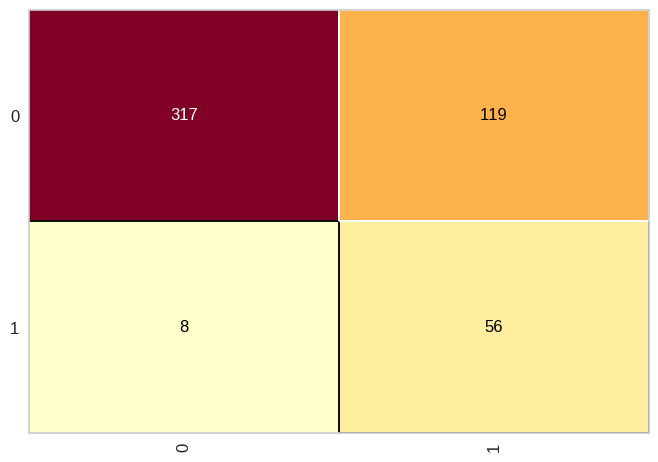

In [38]:
clf_svm = ConfusionMatrix(clf_svm)

clf_svm.fit(X_train, y_train)

clf_svm.score(X_test, y_test)

In [39]:
print(classification_report(y_test, previsoes_svm))

              precision    recall  f1-score   support

           0       0.98      0.73      0.83       436
           1       0.32      0.88      0.47        64

    accuracy                           0.75       500
   macro avg       0.65      0.80      0.65       500
weighted avg       0.89      0.75      0.79       500



# Regressão Logística 

In [40]:
clf_logistic = LogisticRegression(random_state=1, max_iter=300)

clf_logistic.fit(X_train, y_train)

previsoes_logistic = clf_logistic.predict(X_test)

print(f'Acuracia: {accuracy_score(y_test, previsoes_logistic).round(4) * 100} %')


Acuracia: 89.4 %


In [41]:
clf_logistic.intercept_

array([0.00017483])

In [42]:
clf_logistic.coef_

array([[-6.60923632e-05, -1.11737450e-01,  1.09311658e-03]])

0.894

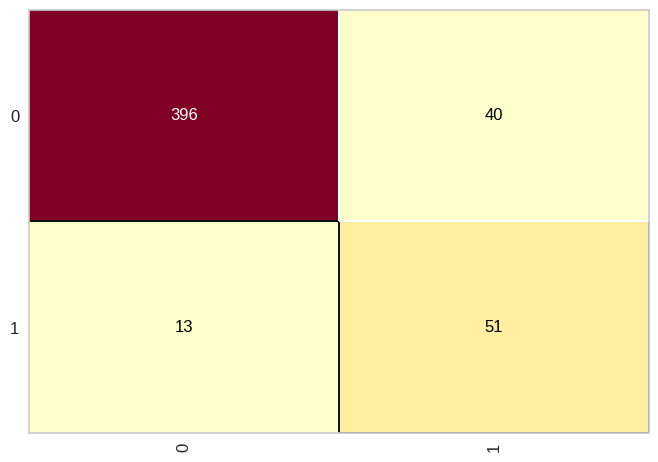

In [43]:
clf_reg_log = ConfusionMatrix(clf_logistic)

clf_reg_log.fit(X_train, y_train)

clf_reg_log.score(X_test, y_test)

In [44]:
print(classification_report(y_test, previsoes_logistic))


              precision    recall  f1-score   support

           0       0.97      0.91      0.94       436
           1       0.56      0.80      0.66        64

    accuracy                           0.89       500
   macro avg       0.76      0.85      0.80       500
weighted avg       0.92      0.89      0.90       500



# XGBoost

In [45]:
clf_xgb = XGBClassifier()

clf_xgb.fit(X_train, y_train)

previsoes_xgb = clf_xgb.predict(X_test)

In [46]:
print(f'Acuracia: {accuracy_score(y_test, previsoes_xgb).round(4) * 100} %')

Acuracia: 98.4 %


0.984

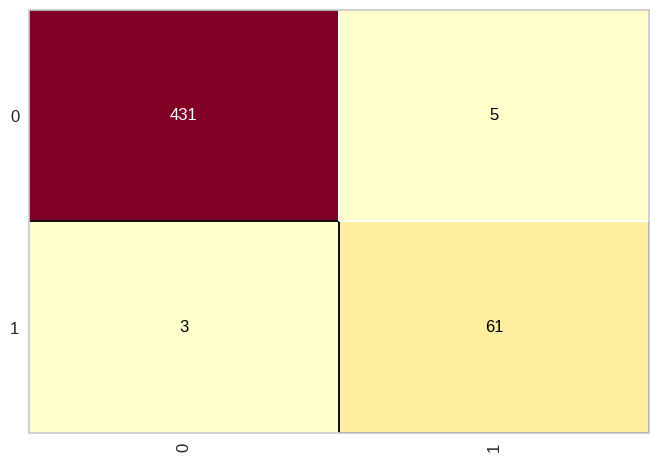

In [47]:
cm = ConfusionMatrix(clf_xgb)

cm.fit(X_train, y_train)

cm.score(X_test, y_test)

In [48]:
print(classification_report(y_test, previsoes_xgb))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       436
           1       0.92      0.95      0.94        64

    accuracy                           0.98       500
   macro avg       0.96      0.97      0.96       500
weighted avg       0.98      0.98      0.98       500



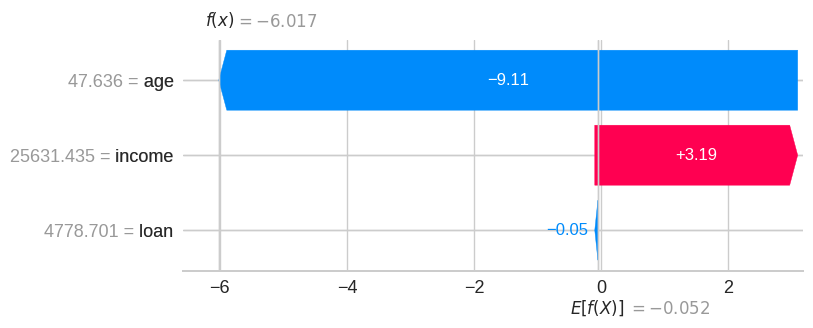

In [49]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])

# CATBoost

In [50]:
clf_cat = CatBoostClassifier()

clf_cat.fit(X_train, y_train)

predict_cat = clf_cat.predict(X_test)
print(f'Acuracia: {accuracy_score(y_test, predict_cat).round(4) * 100}%')

Learning rate set to 0.015396
0:	learn: 0.6640732	total: 48.2ms	remaining: 48.2s
1:	learn: 0.6368325	total: 49.9ms	remaining: 24.9s
2:	learn: 0.6106564	total: 51.5ms	remaining: 17.1s
3:	learn: 0.5902374	total: 52.9ms	remaining: 13.2s
4:	learn: 0.5637082	total: 54.1ms	remaining: 10.8s
5:	learn: 0.5381578	total: 55.3ms	remaining: 9.15s
6:	learn: 0.5140300	total: 56.5ms	remaining: 8.01s
7:	learn: 0.4928090	total: 59.1ms	remaining: 7.33s
8:	learn: 0.4704418	total: 60.8ms	remaining: 6.69s
9:	learn: 0.4495584	total: 62.3ms	remaining: 6.17s
10:	learn: 0.4298640	total: 63.8ms	remaining: 5.74s
11:	learn: 0.4173370	total: 65.3ms	remaining: 5.38s
12:	learn: 0.4019044	total: 66.7ms	remaining: 5.07s
13:	learn: 0.3897062	total: 68.4ms	remaining: 4.82s
14:	learn: 0.3761771	total: 69.7ms	remaining: 4.58s
15:	learn: 0.3608509	total: 70.9ms	remaining: 4.36s
16:	learn: 0.3472076	total: 72.2ms	remaining: 4.18s
17:	learn: 0.3353760	total: 75ms	remaining: 4.09s
18:	learn: 0.3247267	total: 76.9ms	remaining: 

In [51]:
print(classification_report(y_test, predict_cat))

print(f'Acuracia: {accuracy_score(y_test, predict_cat).round(4) * 100}%')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       436
           1       0.94      0.95      0.95        64

    accuracy                           0.99       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.99      0.99      0.99       500

Acuracia: 98.6%


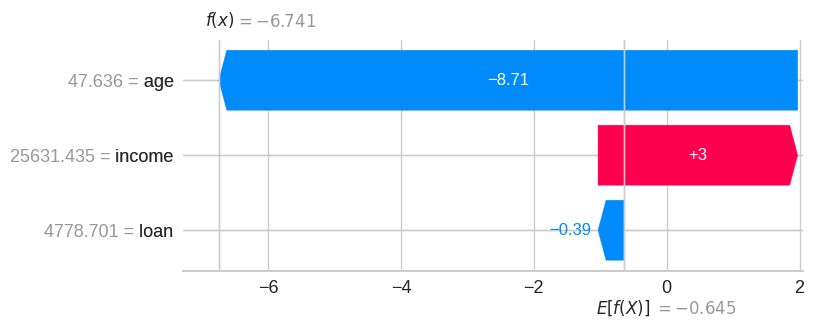

In [52]:
explainer = shap.Explainer(clf_cat)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])

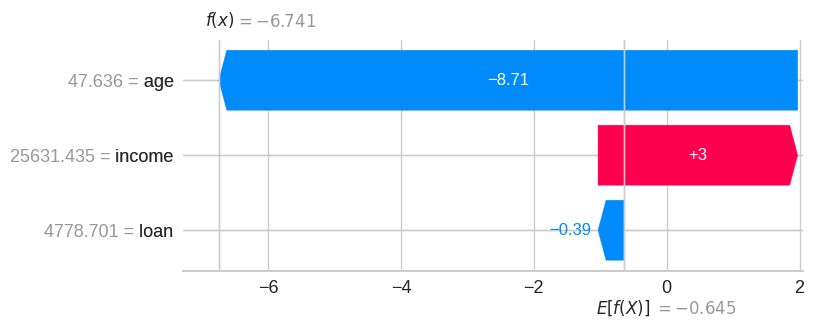

In [53]:
shap.plots.waterfall(shap_values[0])

# LightGBM

In [54]:
clf_lgbm = LGBMClassifier()

clf_lgbm.fit(X_train, y_train)

predict_lgbm = clf_lgbm.predict(X_test)

print(classification_report(y_test, predict_lgbm))
print(f'Acuracia: {accuracy_score(y_test, predict_lgbm).round(4) * 100}%')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       436
           1       0.91      0.97      0.94        64

    accuracy                           0.98       500
   macro avg       0.95      0.98      0.97       500
weighted avg       0.98      0.98      0.98       500

Acuracia: 98.4%
